# Baseline Evaluation of GPT-4o for Functional Representation Extraction

- In this notebook, I use OpenAI's [GPT-4o](https://openai.com/index/hello-gpt-4o/) model for structured functional representation extraction. 
- The goal is to evaluate GPT-4o's performance in extracting structural functional representations from the [VIGGO dataset](https://huggingface.co/datasets/GEM/viggo). 
- This evaluation will serve as the baseline performance for comparison with other models such as `Claude`, `Gemini`, `Llama-3-70b`, and most importantly, with custom fine-tuned open-source models like `llama-3-8b` and `mistral-7b`.

In [488]:
# load required libraries
from datasets import load_dataset
import os, re
import random
from openai import OpenAI
import instructor
from pydantic import BaseModel, Field
import json
import seaborn as sns
import matplotlib.pyplot as plt


## Viggo Dataset
- [VIGGO dataset](https://huggingface.co/datasets/GEM/viggo) is a video game opinions data-to-text generation dataset. 
- It is intended to generate coherent conversational responses based on input functional representations (set of attributes and values). 
- **In this notebook, I use the reverse task, where we generate structured functional representations from the given text.**

### Load the dataset
- Since, I want to evaluate `GPT-4o` for structured representation extraction, I will only consider the VIGGO `validation dataset`.

In [444]:
# load the dataset
dataset = load_dataset("GEM/viggo")
dataset

DatasetDict({
    train: Dataset({
        features: ['gem_id', 'meaning_representation', 'target', 'references'],
        num_rows: 5103
    })
    validation: Dataset({
        features: ['gem_id', 'meaning_representation', 'target', 'references'],
        num_rows: 714
    })
    test: Dataset({
        features: ['gem_id', 'meaning_representation', 'target', 'references'],
        num_rows: 1083
    })
    challenge_train_1_percent: Dataset({
        features: ['gem_id', 'meaning_representation', 'target', 'references'],
        num_rows: 50
    })
    challenge_train_2_percent: Dataset({
        features: ['gem_id', 'meaning_representation', 'target', 'references'],
        num_rows: 103
    })
    challenge_train_5_percent: Dataset({
        features: ['gem_id', 'meaning_representation', 'target', 'references'],
        num_rows: 256
    })
    challenge_train_10_percent: Dataset({
        features: ['gem_id', 'meaning_representation', 'target', 'references'],
        num_rows: 5

In [446]:
# Get the validation dataset
val_dataset = dataset["validation"]

# rename "meaning_representation" to "attributes" and "target" to "text" for consistency
val_dataset = val_dataset.rename_columns({"meaning_representation": "attributes", "target": "text"})

# remove "gem_id" and "reference" columns
val_dataset = val_dataset.remove_columns(["gem_id", "references"])

# delete the original full dataset
del dataset

#### A few data examples

In [180]:
# get 5 random examples from the validation dataset
random_seed = 42
random_idx_list = random.sample(range(len(val_dataset)), 5)
for idx in random_idx_list: print(val_dataset[idx])

random_seed = 42
num_examples = 5
random_idx_list = random.sample(range(len(val_dataset)), num_examples)

for i,idx in enumerate(random_idx_list): 
    print(f"\nExample {idx+1}")
    for key in ['text', 'attributes']: 
        print(f"{key:12s}: {val_dataset[key][idx]}")

{'attributes': "inform(name[Mirror's Edge Catalyst], genres[action-adventure, fighting], player_perspective[first person], has_multiplayer[yes], platforms[PlayStation, Xbox, PC], available_on_steam[no], has_linux_release[yes], has_mac_release[no])", 'text': "Mirror's Edge Catalyst is a first person action-adventure and fighting game. It has multiplayer and released on PlayStation, Xbox, and PC. It has a Linux release but it doesn't have a Mac release and isn't available on Steam."}
{'attributes': 'inform(name[Grand Theft Auto V], release_year[2013], developer[Rockstar North], genres[action-adventure, driving/racing, shooter], player_perspective[first person, third person])', 'text': "If you'd like to play an action-adventure game, Grand Theft Auto V is a first and third person game involving driving and shooting. It was developed by Rockstar North and released in 2013."}
{'attributes': 'inform(name[Horizon: Zero Dawn], esrb[T (for Teen)], genres[action-adventure, role-playing, shooter]

- Upon looking at the examples, the output structured functional representation consists of a single function with attributes and attribute values. 
- According to the [VIGGO's dataset](https://huggingface.co/datasets/GEM/viggo) documentation, the function must be one of the following:
    ```
    ['inform', 'request', 'give_opinion', 'confirm', 'verify_attribute', 'suggest', 'request_explanation', 'recommend', 'request_attribute']
    ```
- While the attributes must be one of these:
  ```
  ['name', 'release_year', 'esrb', 'genres', 'platforms', 'available_on_steam', 'has_linux_release', 'has_mac_release', 'specifier', 'rating', 'player_perspective', 'has_multiplayer', 'developer', 'exp_release_date']
  ```

## Prompt for generating the functional representation

- Since I want to evaluate `GPT-4o` performance on this task, I will first try to build a prompt that can be used to generate the desired correct structured data.
- Fortunately, I can get a head start on the prompt by starting with the prompt template used in [Anyscale's blog](https://www.anyscale.com/blog/fine-tuning-llama-2-a-comprehensive-case-study-for-tailoring-models-to-unique-applications) for the VIGGO dataset.
- The prompt template is a few-shot prompt with examples from each function category to assist the model in understanding the intended output response representation.

In [ ]:
PROMPT_TEMPLATE = """
Given a target sentence construct the underlying meaning representation of the input sentence as a single function with attributes and attribute values. 
This function should describe the target string accurately and the function must be one of the following ['inform', 'request', 'give_opinion', 'confirm', 'verify_attribute', 'suggest', 'request_explanation', 'recommend', 'request_attribute'].

The attributes must be one of the following: ['name', 'exp_release_date', 'release_year', 'developer', 'esrb', 'rating', 'genres', 'player_perspective', 'has_multiplayer', 'platforms', 'available_on_steam', 'has_linux_release', 'has_mac_release', 'specifier']. The order your list the attributes within the function must follow the order listed above. For example the 'name' attribute must always come before the 'exp_release_date' attribute, and so forth.

For each attribute, fill in the corresponding value of the attribute within brackets. A couple of examples are below. Note: you are to output the string after "Output: ". Do not include "Output: " in your answer.

Example 1)
Sentence: Dirt: Showdown from 2012 is a sport racing game for the PlayStation, Xbox, PC rated E 10+ (for Everyone 10 and Older). It's not available on Steam, Linux, or Mac.
Output: inform(name[Dirt: Showdown], release_year[2012], esrb[E 10+ (for Everyone 10 and Older)], genres[driving/racing, sport], platforms[PlayStation, Xbox, PC], available_on_steam[no], has_linux_release[no], has_mac_release[no])

Example 2) 
Sentence: Were there even any terrible games in 2014?
Output: request(release_year[2014], specifier[terrible])

Example 3)
Sentence: Adventure games that combine platforming and puzzles  can be frustrating to play, but the side view perspective is perfect for them. That's why I enjoyed playing Little Nightmares.
Output: give_opinion(name[Little Nightmares], rating[good], genres[adventure, platformer, puzzle], player_perspective[side view])

Example 4)
Sentence: Since we're on the subject of games developed by Telltale Games, I'm wondering, have you played The Wolf Among Us?
Output: recommend(name[The Wolf Among Us], developer[Telltale Games])

Example 5) 
Sentence: Layers of Fear, the indie first person point-and-click adventure game?
Output: confirm(name[Layers of Fear], genres[adventure, indie, point-and-click], player_perspective[first person])	

Example 6) 
Sentence: I bet you like it when you can play games on Steam, like Worms: Reloaded, right?	
Output: suggest(name[Worms: Reloaded], available_on_steam[yes])

Example 7)
Sentence: I recall you saying that you really enjoyed The Legend of Zelda: Ocarina of Time. Are you typically a big fan of games on Nintendo rated E (for Everyone)?	
Output: verify_attribute(name[The Legend of Zelda: Ocarina of Time], esrb[E (for Everyone)], rating[excellent], platforms[Nintendo])

Example 8)
Sentence: So what is it about the games that were released in 2005 that you find so excellent?	
Output: request_explanation(release_year[2005], rating[excellent])

Example 9)
Sentence: Do you think Mac is a better gaming platform than others?
Output: request_attribute(has_mac_release[])

Give the output for the following sentence:
{input}
"""

### Evaluate the prompt on random examples
- I can evaluate the prompt on above random examples to get a sense of how well the model performs with the above prompt

In [24]:
model = "gpt-4o-2024-05-13"
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

In [47]:
# dictionary to store the responses
gpt_responses_dict = {}

# loop through the random indices and get the responses
for i in random_idx_list:
    
    text = val_dataset[i]["text"]
    ground_truth = val_dataset[i]["attributes"]
    
    prompt = PROMPT_TEMPLATE.format(input=text)

    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}],
        max_tokens=256,
    )
    output = response.choices[0].message.content
    
    gpt_responses_dict[i] = {"text": text, "ground_truth": ground_truth, "output": output}

In [48]:
for k,v in gpt_responses_dict.items():
    print(f"Ground Truth: {v['ground_truth']}\nGPT Response: {v['output']}\n\n")

Ground Truth: inform(name[FIFA 12], release_year[2011], esrb[E (for Everyone)], rating[average], genres[simulation, sport])
GPT Response: inform(name[FIFA 12], release_year[2011], esrb[E (for Everyone)], rating[average], genres[sports, simulation])


Ground Truth: request(player_perspective[side view], specifier[easy])
GPT Response: Output: request(genres[side view], rating[top], specifier[easy])


Ground Truth: recommend(name[Need for Speed: The Run], platforms[Xbox])
GPT Response: confirm(name[Need for Speed: The Run], platforms[Xbox])


Ground Truth: verify_attribute(name[Assassin's Creed II], rating[good], genres[action-adventure, platformer], platforms[PlayStation])
GPT Response: verify_attribute(name[Assassin's Creed II], rating[good], genres[action-adventure, platformer], platforms[PlayStation])


Ground Truth: give_opinion(name[BioShock], developer[2K Boston], esrb[M (for Mature)], rating[good])
GPT Response: Output: give_opinion(name[BioShock], developer[2K Boston], rating[goo

### Improve the prompt template
- Upon reviewing the above responses, it appears that the model is able to generate somewhat relevant structural representations for the given input sentences.
- However, the responses are not always accurate, particularly regarding the attributes, their corresponding values, and their order.
- Additionally, for some examples, the model's response starts with 'Output:', which is not ideal.
- This issue might be due to the `Note: you are to output the string after "Output: "...` part being included too early in the prompt. A quick fix for this would be to move this part to the end of the prompt.

In [50]:
PROMPT_TEMPLATE = """
Given a target sentence construct the underlying meaning representation of the input sentence as a single function with attributes and attribute values. 
This function should describe the target string accurately and the function must be one of the following ['inform', 'request', 'give_opinion', 'confirm', 'verify_attribute', 'suggest', 'request_explanation', 'recommend', 'request_attribute'].

The attributes must be one of the following: ['name', 'exp_release_date', 'release_year', 'developer', 'esrb', 'rating', 'genres', 'player_perspective', 'has_multiplayer', 'platforms', 'available_on_steam', 'has_linux_release', 'has_mac_release', 'specifier']. The order your list the attributes within the function must follow the order listed above. For example the 'name' attribute must always come before the 'exp_release_date' attribute, and so forth.

For each attribute, fill in the corresponding value of the attribute within brackets. A couple of examples are below.

Example 1)
Sentence: Dirt: Showdown from 2012 is a sport racing game for the PlayStation, Xbox, PC rated E 10+ (for Everyone 10 and Older). It's not available on Steam, Linux, or Mac.
Output: inform(name[Dirt: Showdown], release_year[2012], esrb[E 10+ (for Everyone 10 and Older)], genres[driving/racing, sport], platforms[PlayStation, Xbox, PC], available_on_steam[no], has_linux_release[no], has_mac_release[no])

Example 2) 
Sentence: Were there even any terrible games in 2014?
Output: request(release_year[2014], specifier[terrible])

Example 3)
Sentence: Adventure games that combine platforming and puzzles  can be frustrating to play, but the side view perspective is perfect for them. That's why I enjoyed playing Little Nightmares.
Output: give_opinion(name[Little Nightmares], rating[good], genres[adventure, platformer, puzzle], player_perspective[side view])

Example 4)
Sentence: Since we're on the subject of games developed by Telltale Games, I'm wondering, have you played The Wolf Among Us?
Output: recommend(name[The Wolf Among Us], developer[Telltale Games])

Example 5) 
Sentence: Layers of Fear, the indie first person point-and-click adventure game?
Output: confirm(name[Layers of Fear], genres[adventure, indie, point-and-click], player_perspective[first person])	

Example 6) 
Sentence: I bet you like it when you can play games on Steam, like Worms: Reloaded, right?	
Output: suggest(name[Worms: Reloaded], available_on_steam[yes])

Example 7)
Sentence: I recall you saying that you really enjoyed The Legend of Zelda: Ocarina of Time. Are you typically a big fan of games on Nintendo rated E (for Everyone)?	
Output: verify_attribute(name[The Legend of Zelda: Ocarina of Time], esrb[E (for Everyone)], rating[excellent], platforms[Nintendo])

Example 8)
Sentence: So what is it about the games that were released in 2005 that you find so excellent?	
Output: request_explanation(release_year[2005], rating[excellent])

Example 9)
Sentence: Do you think Mac is a better gaming platform than others?
Output: request_attribute(has_mac_release[])

Note: you are to output the string after "Output: ". Do not include "Output: " in your answer.

Give the output for the following sentence:
{input}
"""

In [51]:
# dictionary to store the responses
gpt_responses_dict_update1 = {}

# loop through the random indices and get the responses
for i in random_idx_list:
    
    text = val_dataset[i]["text"]
    ground_truth = val_dataset[i]["attributes"]
    
    prompt = PROMPT_TEMPLATE.format(input=text)

    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}],
        max_tokens=256,
    )
    output = response.choices[0].message.content
    
    gpt_responses_dict_update1[i] = {"text": text, "ground_truth": ground_truth, "output": output}

In [65]:
for k,v in gpt_responses_dict_update1.items():
    print(f"Ground Truth: {v['ground_truth']}\nGPT Response: {v['output']}\n\n")

Ground Truth: inform(name[FIFA 12], release_year[2011], esrb[E (for Everyone)], rating[average], genres[simulation, sport])
GPT Response: inform(name[FIFA 12], release_year[2011], esrb[E (for Everyone)], rating[average], genres[sports simulation])


Ground Truth: request(player_perspective[side view], specifier[easy])
GPT Response: request_attribute(genres[easy], player_perspective[side view], rating[tops them all])


Ground Truth: recommend(name[Need for Speed: The Run], platforms[Xbox])
GPT Response: confirm(name[Need for Speed: The Run], platforms[Xbox])


Ground Truth: verify_attribute(name[Assassin's Creed II], rating[good], genres[action-adventure, platformer], platforms[PlayStation])
GPT Response: verify_attribute(name[Assassin's Creed II], rating[good], genres[action-adventure, platformer], platforms[PlayStation])


Ground Truth: give_opinion(name[BioShock], developer[2K Boston], esrb[M (for Mature)], rating[good])
GPT Response: give_opinion(name[BioShock], developer[2K Boston]

> The responses are much better now, with no 'Output:' in the response. Although the responses are still not perfect, the prompt template can be used for evaluation purposes.

## Evaluation criteria for the task

- Next, I need some evaluation criteria to assess the model's performance. I can evaluate the model's performance based on the following binary criteria:
  1. **Function Name Match**: The function name must match the ground truth function name.
  2. **Function and Attributes Match**: The generated function name and attributes must match the ground truth function attributes. However, the order of the attributes does not matter.
  3. **Function, Attributes, and Values Match**: The generated function name, attributes, and values must match the ground truth function attributes and values. The order of the attributes and values does not matter.
  4. **Exact Match**: The generated function must exactly match the ground truth function.

- The above criteria are in order of increasing strictness. The first criterion is the least strict, and the last criterion is the most strict. These criteria will help me evaluate the model's performance.

- **Although not ideal, I can use the `GPT-4` model to evaluate its own performance on the given task.**
- I can write a prompt that asks the model to compare the generated function with the ground truth function and provide a score based on the above evaluation criteria. For example, I can use the following prompt to evaluate the model's performance:

In [342]:
PROMPT_TEMPLATE_SCORE = """I will provide you with two functional representations strings. One will be the ground truth representation (ground_truth) and the other will be a generated representation (generated). You need to compare the generated representation with the ground truth representation and provide the following similarity match in true or false:
1) function_match: The function name is the same but the attributes and values can be different.
2) function_attributes_match: The function and the attributes are the same but the values can be different.
3) function_attributes_values_match: The generated representation has same function and attributes and corresponding values without the same attributes and values order.
4) exact_match: The generated representation is exactly the same as the ground truth representation.
    
A typical functional representation is of this form: function(attribute1[values], attribute2[values], attribute3[values], ...). 

Please provide the output in JSON format.

Given the following two functional representation, provide the similarity scores for the following:

ground_truth: {ground_truth}

generated: {generated}
"""


### Calculate the evaluation score on some generated response

In [343]:
# Get the responses for the evaluation criteria
for k,v in gpt_responses_dict_update1.items():
    print(k)
    print(f"Ground Truth: {v['ground_truth']}\nGPT Response: {v['output']}\n")
        
    prompt = PROMPT_TEMPLATE_SCORE.format(ground_truth=v['ground_truth'], generated=v['output'])

    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}],
        max_tokens=256,
    )
    output = response.choices[0].message.content
    print(output,"\n\n")

120
Ground Truth: inform(name[FIFA 12], release_year[2011], esrb[E (for Everyone)], rating[average], genres[simulation, sport])
GPT Response: inform(name[FIFA 12], release_year[2011], esrb[E (for Everyone)], rating[average], genres[sports simulation])

```json
{
  "function_match": true,
  "function_attributes_match": true,
  "function_attributes_values_match": false,
  "exact_match": false
}
``` 


568
Ground Truth: request(player_perspective[side view], specifier[easy])
GPT Response: request_attribute(genres[easy], player_perspective[side view], rating[tops them all])

```json
{
  "function_match": false,
  "function_attributes_match": false,
  "function_attributes_values_match": false,
  "exact_match": false
}
``` 


224
Ground Truth: recommend(name[Need for Speed: The Run], platforms[Xbox])
GPT Response: confirm(name[Need for Speed: The Run], platforms[Xbox])

```json
{
    "function_match": false,
    "function_attributes_match": false,
    "function_attributes_values_match": fals

### Improve the evaluation task using `Instructor`

- Looking at the output, I can see that the model is able to evaluate its own performance based on the provided evaluation criteria. 
- However, I need the evaluation scores in a more structured format to analyze the model's performance effectively. 
- A better way to achieve this is by using a package like [instructor](https://python.useinstructor.com/) to obtain the evaluation scores in a structured format. 
- I can use the following code and a modified score prompt template to get the evaluation scores in a structured format.

In [345]:
# Define the pydantic model for the evaluation function

class EvaluateFunctionRepresentation(BaseModel):
    function_match: bool = Field(description="The function name is the same but the attributes and values can be different.")
    function_attribute_match: bool = Field(description="The function and the attributes are the same but the values can be different.")
    function_attributes_values_match: bool = Field(description="The generated representation has same function and attributes and corresponding values without the same attributes and values order.")
    exact_match: bool = Field(description="The generated representation is exactly the same as the ground truth representation.")

In [349]:
PROMPT_TEMPLATE_SCORE_EVAL = """I will provide you with two functional representations strings. One will be the ground truth representation (ground_truth) and the other will be a generated representation (generated). You need to compare the generated representation with the ground truth representation and provide the following similarity match in true or false:
1) function_match
2) function_attributes_match
3) function_attributes_values_match
4) exact_match

A typical functional representation is of this form: function(attribute1[values], attribute2[values], attribute3[values], ...). 

Given the following two functional representation, provide the similarity scores for the following:

ground_truth: {ground_truth}

generated: {generated}

Let's think step by step.
"""

In [ ]:
client_eval = instructor.patch(OpenAI(api_key=os.getenv("OPENAI_API_KEY")), mode=instructor.Mode.JSON)

In [350]:
for k,v in gpt_responses_dict_update1.items():
    print(f"Index: {k}\nGround Truth: {v['ground_truth']}\nGPT Response: {v['output']}\n")
    
    prompt = PROMPT_TEMPLATE_SCORE_EVAL.format(ground_truth=v['ground_truth'], generated=v['output'])

    response = client_eval.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}],
        max_tokens=256,
        response_model=EvaluateFunctionRepresentation,
        max_retries=2,
    )
    
    for k,v in response.model_dump().items(): print(f"{k:40s}: {v}")
    print("\n\n")

Index: 120
Ground Truth: inform(name[FIFA 12], release_year[2011], esrb[E (for Everyone)], rating[average], genres[simulation, sport])
GPT Response: inform(name[FIFA 12], release_year[2011], esrb[E (for Everyone)], rating[average], genres[sports simulation])

function_match                          : True
function_attribute_match                : True
function_attributes_values_match        : False
exact_match                             : False



Index: 568
Ground Truth: request(player_perspective[side view], specifier[easy])
GPT Response: request_attribute(genres[easy], player_perspective[side view], rating[tops them all])

function_match                          : False
function_attribute_match                : False
function_attributes_values_match        : False
exact_match                             : False



Index: 224
Ground Truth: recommend(name[Need for Speed: The Run], platforms[Xbox])
GPT Response: confirm(name[Need for Speed: The Run], platforms[Xbox])

function_match  

> Now, the evaluation scores are in a structured format that can be easily analyzed.

## Generate the responses for the full dataset

In [355]:
gpt_responses_dict = {}
for i in range(len(val_dataset)):
    if i % 100 == 0: print(f"Processing example {i} of {len(val_dataset)}")
    text = val_dataset[i]["text"]
    ground_truth = val_dataset[i]["attributes"]
    
    prompt = PROMPT_TEMPLATE.format(input=text)

    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}],
        max_tokens=256,
    )
    output = response.choices[0].message.content
    
    gpt_responses_dict[i] = {"text": text, "ground_truth": ground_truth, "output": output}

Processing example 0 of 714
Processing example 100 of 714
Processing example 200 of 714
Processing example 300 of 714
Processing example 400 of 714
Processing example 500 of 714
Processing example 600 of 714
Processing example 700 of 714
CPU times: user 5.86 s, sys: 262 ms, total: 6.12 s
Wall time: 13min 22s


> took around 13 mins 22s to run 714 examples (approx 1.1s per example)

In [357]:
# save the responses to a file for future reference
with open("gpt_responses_viggo_eval.json", "w") as f:
    json.dump(gpt_responses_dict, f)

## Generate the evaluation scores for the full dataset

In [372]:
scores_dict = {}
for i, (k,v) in enumerate(gpt_responses_dict.items()):
    if i%100 ==0: print(f"Processing example {i} of {len(gpt_responses_dict)}")
    prompt = PROMPT_TEMPLATE_SCORE_EVAL.format(ground_truth=v['ground_truth'], generated=v['output'])

    response = client_eval.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}],
        max_tokens=256,
        response_model=EvaluateFunctionRepresentation,
        max_retries=2,
    )
    
    scores_dict[k] = response.model_dump()

Processing example 0 of 714
Processing example 100 of 714
Processing example 200 of 714
Processing example 300 of 714
Processing example 400 of 714
Processing example 500 of 714
Processing example 600 of 714
Processing example 700 of 714


### Get the average scores


In [482]:
avg_scores = {k: sum([v[k] for v in scores_dict.values()])/len(scores_dict) for k in scores_dict[0].keys()}
for k,v in avg_scores.items(): print(f"{k:40s}: {v:.2f}")

function_match                          : 0.80
function_attribute_match                : 0.74
function_attributes_values_match        : 0.49
exact_match                             : 0.30


### Visualize the average scores for the evaluation criteria

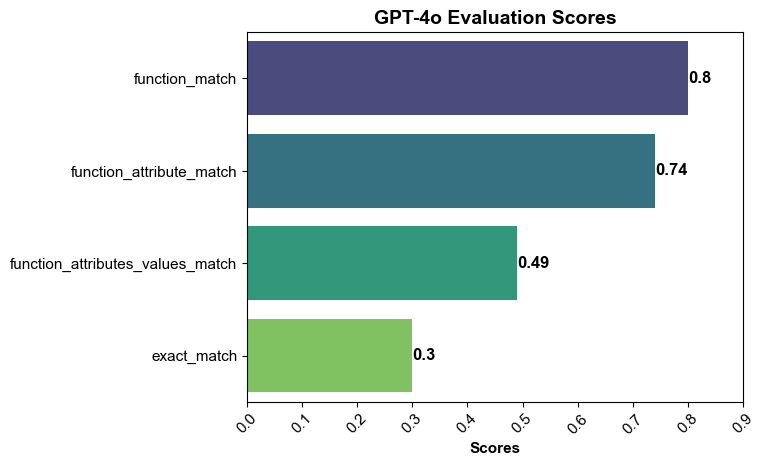

In [486]:
# make a bar plot of the scores 
scores_list = [round(avg_scores[k],2) for k in avg_scores.keys()]
scores_labels = [k for k in avg_scores.keys()]

# make the bar plot
ax = sns.barplot(x=scores_list, y=scores_labels, hue=scores_labels, palette="viridis")

# set the title
plt.title("GPT-4o Evaluation Scores", fontsize=14, fontweight="bold", fontname="Arial")

# set x and y labels
plt.xlabel("Scores", fontsize=11, fontname="Arial", fontweight="bold")
plt.ylabel("",fontsize=11, fontname="Arial", fontweight="bold")

# set x and y ticks
plt.yticks(fontsize=11, fontname="Arial")
plt.xticks(fontsize=11, fontname="Arial", rotation=45)

# set x-axis limits
plt.xlim(0, 0.9)

# score values on the bars
for i in range(len(scores_list)):
    plt.text(scores_list[i], i, scores_list[i], va='center', fontsize=12, fontname="Arial", fontweight="bold")

# save the plot
plt.savefig("gpt-4o-evaluation-scores.png", dpi=300, bbox_inches="tight")


In [492]:
# Save the evaluation scores, avg. scores to files for future reference.
with open("gpt-4o-evaluation-scores.json", "w") as f:
    json.dump(scores_dict, f)

with open("gpt-4o-avg-evaluation-scores.json", "w") as f:
    json.dump(avg_scores, f)

> The task of generating functional representations from natural language sentences is challenging. The best the model can do is to provide the correct function name `80%` of the time whereas the exact match is only for 30% of the examples.

## Links

- Alex Strict van Linchoten blog: [Evaluating the Baseline Performance of GPT-4-Turbo for Structured Data Extraction](https://mlops.systems/posts/2024-06-03-isafpr-evaluating-baseline.html)
- Viggo's dataset: [HuggingFace Link](https://huggingface.co/datasets/GEM/viggo)
- Anyscale's blog on fine-tuning Llama models for domain applications: [Fine-Tuning Llama-2: A Comprehensive Case Study for Tailoring Models to Unique Applications](https://www.anyscale.com/blog/fine-tuning-llama-2-a-comprehensive-case-study-for-tailoring-models-to-unique-applications)